# Analise de dados do Banco de dados da federal election commission em 2012

In [1]:
# Importando as bibliotecas
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Carregando o arquivo csv e mostrando as informações
fec = pd.read_csv('datasets/fec/P00000001-ALL.csv', low_memory=False)

fec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001731 entries, 0 to 1001730
Data columns (total 16 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   cmte_id            1001731 non-null  object 
 1   cand_id            1001731 non-null  object 
 2   cand_nm            1001731 non-null  object 
 3   contbr_nm          1001731 non-null  object 
 4   contbr_city        1001712 non-null  object 
 5   contbr_st          1001727 non-null  object 
 6   contbr_zip         1001620 non-null  object 
 7   contbr_employer    988002 non-null   object 
 8   contbr_occupation  993301 non-null   object 
 9   contb_receipt_amt  1001731 non-null  float64
 10  contb_receipt_dt   1001731 non-null  object 
 11  receipt_desc       14166 non-null    object 
 12  memo_cd            92482 non-null    object 
 13  memo_text          97770 non-null    object 
 14  form_tp            1001731 non-null  object 
 15  file_num           1001731 non-n

In [3]:
# Exemplo de registro do DataFrame
fec.iloc[123456]

cmte_id                             C00431445
cand_id                             P80003338
cand_nm                         Obama, Barack
contbr_nm                         ELLMAN, IRA
contbr_city                             TEMPE
contbr_st                                  AZ
contbr_zip                          852816719
contbr_employer      ARIZONA STATE UNIVERSITY
contbr_occupation                   PROFESSOR
contb_receipt_amt                        50.0
contb_receipt_dt                    01-DEC-11
receipt_desc                              NaN
memo_cd                                   NaN
memo_text                                 NaN
form_tp                                 SA17A
file_num                               772372
Name: 123456, dtype: object

In [4]:
# Uma lista com todos os candidatos políticos únicos pode se obtida pelo método unique()
unique_cards = fec.cand_nm.unique()
unique_cards

array(['Bachmann, Michelle', 'Romney, Mitt', 'Obama, Barack',
       "Roemer, Charles E. 'Buddy' III", 'Pawlenty, Timothy',
       'Johnson, Gary Earl', 'Paul, Ron', 'Santorum, Rick',
       'Cain, Herman', 'Gingrich, Newt', 'McCotter, Thaddeus G',
       'Huntsman, Jon', 'Perry, Rick'], dtype=object)

In [5]:
# Mostrando o unique_cards no índice 2
unique_cards[2]

'Obama, Barack'

In [6]:
# Uma forma de indicar a filiação partidária é usar um dicionário
parties = {'Bachmann, Michelle': 'Republican',
            'Romney, Mitt': 'Republican',
            'Obama, Barack': 'Democrat',
            "Roemer, Charles E. 'Buddy' III": 'Republican',
            'Pawlenty, Timothy': 'Republican',
            'Johnson, Gary Earl': 'Republican',
            'Paul, Ron': 'Republican',
            'Santorum, Rick': 'Republican',
            'Cain, Herman': 'Republican',
            'Gingrich, Newt': 'Republican',
            'McCotter, Thaddeus G': 'Republican',
            'Huntsman, Jon': 'Republican',
            'Perry, Rick': 'Republican'}

In [7]:
# Filtrando por índice
fec.cand_nm[123456:123461]

123456    Obama, Barack
123457    Obama, Barack
123458    Obama, Barack
123459    Obama, Barack
123460    Obama, Barack
Name: cand_nm, dtype: object

In [8]:
# Mapeamento com o método map() e podemos gerar um array de partidos políticos a partir dos nomes de candidatos
fec.cand_nm[123456:123461].map(parties)

123456    Democrat
123457    Democrat
123458    Democrat
123459    Democrat
123460    Democrat
Name: cand_nm, dtype: object

In [9]:
# Adicionar-o como uma coluna e contando os valores
fec['party'] = fec.cand_nm.map(parties)

fec['party'].value_counts()

party
Democrat      593746
Republican    407985
Name: count, dtype: int64

In [10]:
# Esses dados incluem tanto as contribuições quanto as restituições (valores negativos de contribuição)
(fec["contb_receipt_amt"] > 0).value_counts()

contb_receipt_amt
True     991475
False     10256
Name: count, dtype: int64

In [11]:
# Restringirei o conjunto de dados as contribuições positivas
fec = fec[fec["contb_receipt_amt"] > 0]

In [12]:
# Subconjunto com as contribuições somente de 'Obama, Barack' e 'Romney, Mitt'
fec_mrbo = fec[fec["cand_nm"].isin(["Obama, Barack", "Romney, Mitt"])]

In [13]:
# Obter o número total de doações por profissão
fec["contbr_occupation"].value_counts()[:10]

contbr_occupation
RETIRED                                   233990
INFORMATION REQUESTED                      35107
ATTORNEY                                   34286
HOMEMAKER                                  29931
PHYSICIAN                                  23432
INFORMATION REQUESTED PER BEST EFFORTS     21138
ENGINEER                                   14334
TEACHER                                    13990
CONSULTANT                                 13273
PROFESSOR                                  12555
Name: count, dtype: int64

In [14]:
# Usando o dict.get para mapear as profissões
occ_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
    'INFORMATION REQUESTED': 'NOT PROVIDED',
    'INFORMATION REQUESTED (BEST EFFORTS)': 'NOT PROVIDED',
    'C.E.O': 'CEO'
}

In [15]:
# Se não houver nenhum mapeamento disponível, devolve x
def get_occ(x):
    return occ_mapping.get(x, x)

fec["contbr_occupation"] = fec["contbr_occupation"].map(get_occ)

In [16]:
# Usando o dict.get para mapear os empregadores
emp_mapping = {
    'INFORMATION REQUESTED PER BEST EFFORTS': 'NOT PROVIDED',
    'INFORMATION REQUESTED': 'NOT PROVIDED',
    'SELF': 'SELF_EMPLOYED',
    'SELF EMPLOYED': 'SELF_EMPLOYED'
}

In [17]:
# Se não houver nenhum mapeamento disponível, devolve x
def get_emp(x):
    return emp_mapping.get(x, x)

fec["contbr_employer"] = fec["contbr_employer"].map(get_emp)

In [18]:
# Usar pivot_table para agregar os dados por partido e por profissão e filtrar a fim de obter o subconjunto 
# daqueles que doaram no mínimo 2 milhões de dólares
by_occupation = fec.pivot_table("contb_receipt_amt", index="contbr_occupation", columns="party", aggfunc="sum")
over_2mm = by_occupation[by_occupation.sum(axis="columns") > 2000000]
over_2mm

party,Democrat,Republican
contbr_occupation,,
ATTORNEY,11141982.97,7477194.43
C.E.O.,1690.00,2592983.11
CEO,2074284.79,1640758.41
CONSULTANT,2459912.71,2544725.45
ENGINEER,951525.55,1818373.70
EXECUTIVE,1355161.05,4138850.09
HOMEMAKER,4248875.80,13634275.78
INVESTOR,884133.00,2431768.92
LAWYER,3160478.87,391224.32


In [19]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Axes: ylabel='contbr_occupation'>

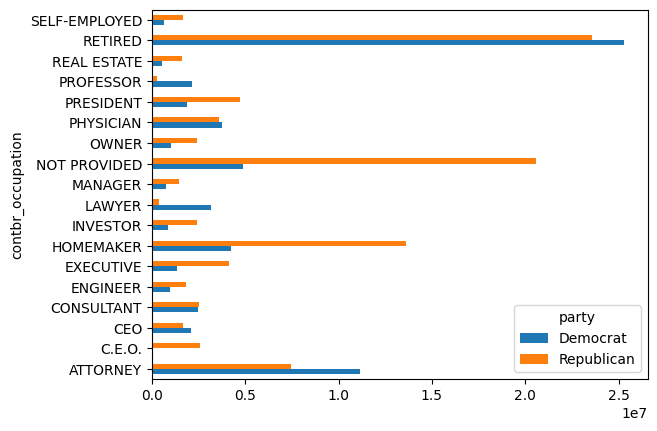

In [20]:
# Plotagem de barras horizontais
over_2mm.plot(kind="barh")

In [21]:
# Agrupar os dados por nome de candidato e usar uma variante do método get_top_amounts
def get_top_amounts(group, key, n=5):
    totals = group.groupby(key)['contb_receipt_amt'].sum()
    return totals.nlargest(n)

In [22]:
# Agregação por profissão
grouped = fec_mrbo.groupby('cand_nm')
grouped.apply(get_top_amounts, 'contbr_occupation', n=7)

cand_nm        contbr_occupation                     
Obama, Barack  RETIRED                                   25305116.38
               ATTORNEY                                  11141982.97
               INFORMATION REQUESTED                      4866973.96
               HOMEMAKER                                  4248875.80
               PHYSICIAN                                  3735124.94
               LAWYER                                     3160478.87
               CONSULTANT                                 2459912.71
Romney, Mitt   RETIRED                                   11508473.59
               INFORMATION REQUESTED PER BEST EFFORTS    11396894.84
               HOMEMAKER                                  8147446.22
               ATTORNEY                                   5364718.82
               PRESIDENT                                  2491244.89
               EXECUTIVE                                  2300947.03
               C.E.O.                            

In [23]:
# Agregação por empregador
grouped.apply(get_top_amounts, 'contbr_employer', n=10)

cand_nm        contbr_employer                       
Obama, Barack  RETIRED                                   22694358.85
               SELF-EMPLOYED                             17080985.96
               NOT EMPLOYED                               8586308.70
               INFORMATION REQUESTED                      5053480.37
               HOMEMAKER                                  2605408.54
               SELF                                       1076531.20
               SELF EMPLOYED                               469290.00
               STUDENT                                     318831.45
               VOLUNTEER                                   257104.00
               MICROSOFT                                   215585.36
Romney, Mitt   INFORMATION REQUESTED PER BEST EFFORTS    12059527.24
               RETIRED                                   11506225.71
               HOMEMAKER                                  8147196.22
               SELF-EMPLOYED                     

In [24]:
# Usar a função cut a fim de tornar discretos os valores das contribuições, separando-os em buckets
bins = np.array([0, 1, 10, 100, 1000, 10000, 100_000, 1_000_000, 10_000_000])
labels = pd.cut(fec_mrbo["contb_receipt_amt"], bins)
labels

411         (10, 100]
412       (100, 1000]
413       (100, 1000]
414         (10, 100]
415         (10, 100]
             ...     
701381      (10, 100]
701382    (100, 1000]
701383        (1, 10]
701384      (10, 100]
701385    (100, 1000]
Name: contb_receipt_amt, Length: 694282, dtype: category
Categories (8, interval[int64, right]): [(0, 1] < (1, 10] < (10, 100] < (100, 1000] < (1000, 10000] < (10000, 100000] < (100000, 1000000] < (1000000, 10000000]]

In [25]:
# Agrupar os dados para Obama e Romney por nome e rótulo do compartimento (bin)
grouped = fec_mrbo.groupby(["cand_nm", labels])
grouped.size().unstack(level=0)

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",493,77
"(1, 10]",40070,3681
"(10, 100]",372280,31853
"(100, 1000]",153991,43357
"(1000, 10000]",22284,26186
"(10000, 100000]",2,1
"(100000, 1000000]",3,0
"(1000000, 10000000]",4,0


In [26]:
plt.figure()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [27]:
# Somar os valores das contribuições e normalizar nos buckets a fim de visualizar o percentual 
# sobre o total de doações de cada montante, por candidato
bucket_sums = grouped["contb_receipt_amt"].sum().unstack(level=0)
normed_sums = bucket_sums.div(bucket_sums.sum(axis="columns"), axis="index")
normed_sums

cand_nm,"Obama, Barack","Romney, Mitt"
contb_receipt_amt,,
"(0, 1]",0.805182,0.194818
"(1, 10]",0.918767,0.081233
"(10, 100]",0.910769,0.089231
"(100, 1000]",0.710176,0.289824
"(1000, 10000]",0.447326,0.552674
"(10000, 100000]",0.823120,0.176880
"(100000, 1000000]",1.000000,0.000000
"(1000000, 10000000]",1.000000,0.000000


<Axes: ylabel='contb_receipt_amt'>

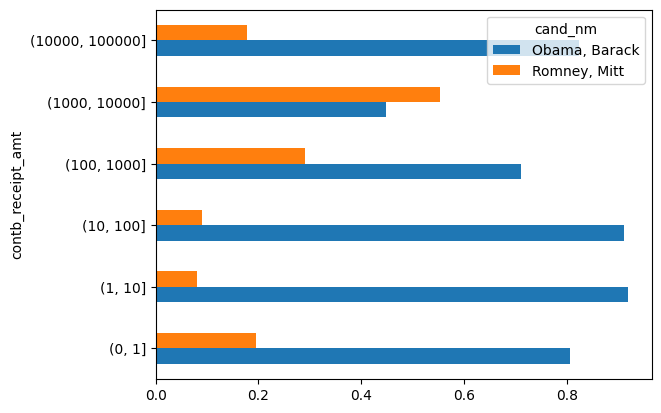

In [28]:
# Plotagem do gráfico de barras
normed_sums[:-2].plot(kind="barh")

In [29]:
# Agregar os dados por candidatos e por estado
grouped = fec_mrbo.groupby(["cand_nm", "contbr_st"])
totals = grouped["contb_receipt_amt"].sum().unstack(level=0).fillna(0)
totals = totals[totals.sum(axis="columns") > 100000]
totals.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,281840.15,86204.24
AL,543123.48,527303.51
AR,359247.28,105556.00
AZ,1506476.98,1888436.23
CA,23824984.24,11237636.60
CO,2132429.49,1506714.12
CT,2068291.26,3499475.45
DC,4373538.80,1025137.50
DE,336669.14,82712.00


In [30]:
# Dividir cada linha pelo valor total da contribuição, o percentual relativo do total das doações por estado 
# para cada candidato
percent = totals.div(totals.sum(axis="columns"), axis="index")
percent.head(10)

cand_nm,"Obama, Barack","Romney, Mitt"
contbr_st,,
AK,0.765778,0.234222
AL,0.507390,0.492610
AR,0.772902,0.227098
AZ,0.443745,0.556255
CA,0.679498,0.320502
CO,0.585970,0.414030
CT,0.371476,0.628524
DC,0.810113,0.189887
DE,0.802776,0.197224
